In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('drive/MyDrive/dataset')

sentiment_types = os.listdir('drive/MyDrive/dataset')

print(sentiment_types)

['Negative', 'Neutral', 'Positive']


In [ ]:
sentiments = []

for item in sentiment_types:
  all_sentiments = os.listdir('drive/MyDrive/dataset'+'/'+item)

  for sentiment in all_sentiments:
    sentiments.append((item,str('drive/MyDrive/dataset'+'/'+item)+'/'+sentiment))
    print(sentiments)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
sentiments_df = pd.DataFrame(data = sentiments,columns=['sentiment type','image'])
print(sentiments_df.head())
print("Total number of sentiments",len(sentiments_df))

sentiment_count = sentiments_df['sentiment type'].value_counts()

print("sentiments in each catagory")
print(sentiment_count)

  sentiment type                                              image
0       Negative  drive/MyDrive/dataset/Negative/69066454-4d14-4...
1       Negative  drive/MyDrive/dataset/Negative/690a97e6-327d-4...
2       Negative  drive/MyDrive/dataset/Negative/688a1983-3c5f-4...
3       Negative  drive/MyDrive/dataset/Negative/693c37e0-15bc-4...
4       Negative  drive/MyDrive/dataset/Negative/696448cc-ceee-4...
Total number of sentiments 2432
sentiments in each catagory
Negative    1695
Positive     648
Neutral       89
Name: sentiment type, dtype: int64


In [ ]:
import cv2 as cv
from matplotlib.pyplot import imshow
path = "drive/MyDrive/dataset/"
c = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
}
im_size = 128

images = []
labels = []

for i in sentiment_types:
  dataset_path=path+str(i)
  filenames = [i for i in os.listdir(dataset_path)]
  for f in filenames:
    img = cv.imread(dataset_path+'/'+f)
    img = cv.resize(img,(im_size,im_size))
    #img = cv.Canny(img,100,200)
    #imshow(img)
    img = preprocess_input(img)
    #imshow(img)
    images.append(img)
    labels.append(i)
images = np.array(images)
labels = np.array(labels)
images = images/255.0
images.shape

(2432, 128, 128, 3)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_path = 'drive/MyDrive/dataset'
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (im_size, im_size),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
Y=training_set.classes

Found 2432 images belonging to 3 classes.


In [ ]:
training_set.class_indices

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter
images = images.reshape(images.shape[0],3*im_size*im_size)
ros = SMOTE(random_state = 50,sampling_strategy='not majority',k_neighbors=2)
#ros = RandomOverSampler(s)
images,Y = ros.fit_resample(images,Y)
print(images.shape)
print(Y.shape)
print(images.shape[0])
images = images.reshape(images.shape[0],im_size,im_size,3)

(5085, 49152)
(5085,)
5085


In [ ]:
#images = images.reshape(5085,224,224,3)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#images,Y = shuffle(images,Y,random_state=5)

train_x,test_x,train_y,test_y = train_test_split(images, Y,test_size=0.2, random_state=50)
#sm = SMOTE('minority')
#train_x,train_y = mdo.fit_transform(np.copy(train_x), np.copy(train_y))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(4068, 128, 128, 3)
(4068,)
(1017, 128, 128, 3)
(1017,)


In [ ]:
vgg = VGG19(input_shape=(im_size,im_size,3), weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

80150528/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model
history = model.fit(
  train_x,
  train_y,
  validation_data=(test_x,test_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
128/128 [==============================] - 22s 89ms/step - loss: 0.8082 - accuracy: 0.6357 - val_loss: 0.6568 - val_accuracy: 0.7424
Epoch 2/10
128/128 [==============================] - 9s 72ms/step - loss: 0.5484 - accuracy: 0.7820 - val_loss: 0.5348 - val_accuracy: 0.7847
Epoch 3/10
128/128 [==============================] - 9s 73ms/step - loss: 0.4228 - accuracy: 0.8547 - val_loss: 0.5200 - val_accuracy: 0.7974
Epoch 4/10
128/128 [==============================] - 9s 74ms/step - loss: 0.3656 - accuracy: 0.8764 - val_loss: 0.4828 - val_accuracy: 0.8043
Epoch 5/10
128/128 [==============================] - 9s 74ms/step - loss: 0.3088 - accuracy: 0.9012 - val_loss: 0.4483 - val_accuracy: 0.8102
Epoch 6/10
128/128 [==============================] - 10s 74ms/step - loss: 0.2728 - accuracy: 0.9172 - val_loss: 0.4517 - val_accuracy: 0.8142
Epoch 7/10
128/128 [==============================] - 10s 74ms/step - loss: 0.2533 - accuracy: 0.9206 - val_loss: 0.4608 - val_accuracy: 0.8

In [ ]:
model.save("new.h5")

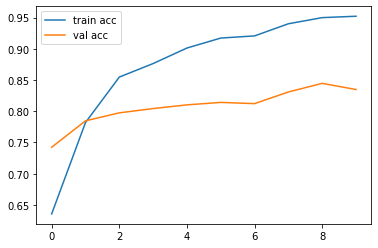

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

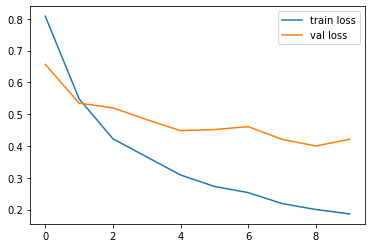

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

32/32 [==============================] - 2s 61ms/step - loss: 0.4213 - accuracy: 0.8348


[0.4212768077850342, 0.8348082304000854]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
import numpy as np
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,test_y))
print(confusion_matrix(y_pred,test_y))
f1_score(y_pred,test_y,average='weighted')

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       349
           1       0.94      0.99      0.97       341
           2       0.76      0.77      0.76       327

    accuracy                           0.83      1017
   macro avg       0.83      0.83      0.83      1017
weighted avg       0.83      0.83      0.83      1017

[[259  13  77]
 [  0 339   2]
 [ 67   9 251]]


0.8328622879111154

In [ ]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image

images = ['00bf1649-7f48-44ce-b208-a648023bd65a.jpg','28480eff-e6be-4ab2-9343-ed05eb0b60d7.jpg','01af425e-61c8-4e5b-9cb4-bdff3f407037.jpg']
X = []
for img_path in images:
  img = cv.imread(img_path)
  img = cv.resize(img,(im_size,im_size))
  #img = cv.Canny(img,100,200)
  img = preprocess_input(img)
  x = np.array(img)
  x=x/255.0
  x = np.expand_dims(x,axis = 0)
  X.append(x)
  my_image = imread(img_path)
  plt.figure()
  imshow(my_image)

error: ignored

In [ ]:




labeling = ['Negative','Neutral','Positive']
for i in range (3):
  pred = model.predict(X[i])
  print(pred)
  print(labeling[np.argmax(pred)])

In [ ]:
model.save("vgg19_sampled_working.h5")